# Vectorized Functions

## The Essence of Vectorization

In mathematics, we often apply an operation to an entire set of numbers at once. In programming, this is called **vectorization**. Instead of writing a `for` loop to handle each element individually, you use functions that operate on the entire array in a single, expressive statement. We've already seen this with the dot-operator (`.`).

Julia provides a rich library of these vectorized functions. They lead to code that is not only shorter and more readable, but often significantly faster, as Julia can use highly optimized, low-level routines to perform the computation. Let's explore some of the most common types of array functions, starting with **reduction functions**.

### Reduction Functions: Summarizing Your Data

A reduction function takes an array and "reduces" it to a single value. A perfect example is summing all the elements:

In [1]:
# Create a vector of 5 random integers between 1 and 100.
x = rand(1:100, 5)

# The sum() function is a clean and efficient way to add up all elements.
println("Sum of ", x, " = ", sum(x))

Sum of [97, 100, 44, 14, 100] = 355


Many reduction functions can also operate along a specific dimension of a multi-dimensional array using the `dims` keyword argument. This allows you to, for example, compute column-wise or row-wise summaries.

- `dims=1`: Operates along the first dimension (collapses the rows to produce a result for each **column**).
- `dims=2`: Operates along the second dimension (collapses the columns to produce a result for each **row**).

In [2]:
# Let's create a 3x5 matrix to see this in action.
A = rand(-100:100, 3, 5)

3×5 Matrix{Int64}:
 -34   81  97  -13  -36
   7  -55  50   95  -41
  41  -37  73  -66  -99

In [3]:
# Sum down the columns (dims=1), producing a 1x5 row vector of column sums.
sum(A, dims=1)

1×5 Matrix{Int64}:
 14  -11  220  16  -176

In [4]:
# Sum across the rows (dims=2), producing a 3x1 column vector of row sums.
sum(A, dims=2)

3×1 Matrix{Int64}:
  95
  56
 -88

> **Note: Preserving Dimensions**
> Notice that when you reduce a 2D array, the result is still a 2D array (a `1x5` or `3x1` matrix), not a 1D vector. Julia does this to maintain type consistency. If you need a true 1D vector as the output, you can easily "flatten" the result using `[:]`.

In [5]:
# The result of the column-wise sum is now a 5-element Vector.
sum(A, dims=1)[:]

5-element Vector{Int64}:
   14
  -11
  220
   16
 -176

Here are a few other essential reduction functions:

In [6]:
x = rand(1:100, 5)
display(x)

# Calculate the product of all elements.
prod(x)

5-element Vector{Int64}:
  4
  5
 61
 81
 59

5830380

In [7]:
display(A)

# Find the largest element in each column.
display(maximum(A, dims=1))

# Find the smallest element in each column.
display(minimum(A, dims=1))

3×5 Matrix{Int64}:
 -34   81  97  -13  -36
   7  -55  50   95  -41
  41  -37  73  -66  -99

1×5 Matrix{Int64}:
 41  81  97  95  -36

1×5 Matrix{Int64}:
 -34  -55  50  -66  -99

### Cumulative Functions: Building on What Came Before

Cumulative functions are another flavor of vectorization. Instead of reducing the array to a single value, they produce an array of the same size where each element is the result of an operation on all *preceding* elements. The most common are `cumsum` and `cumprod`.

In [8]:
x = 1:5

# Cumulative sum: the k-th element is the sum of x[1] through x[k].
display(cumsum(x)) # Expected: [1, 1+2, 1+2+3, ...]

# Cumulative product: the k-th element is the product of x[1] through x[k] (factorial).
display(cumprod(x)) # Expected: [1, 1*2, 1*2*3, ...]

5-element Vector{Int64}:
  1
  3
  6
 10
 15

5-element Vector{Int64}:
   1
   2
   6
  24
 120

In [9]:
# Like before, we can apply these along specific dimensions.
A = reshape(1:6, 2, 3)

2×3 reshape(::UnitRange{Int64}, 2, 3) with eltype Int64:
 1  3  5
 2  4  6

In [10]:
# Perform a cumulative sum down the columns (dims=1).
cumsum(A, dims=1)

2×3 Matrix{Int64}:
 1  3   5
 3  7  11

In [11]:
# Perform a cumulative product across the rows (dims=2).
cumprod(A, dims=2)

2×3 Matrix{Int64}:
 1  3  15
 2  8  48

## Case Study: Vectorizing a Taylor Polynomial

Let's revisit the Taylor series for $\cos(x)$ that we previously implemented with a `for` loop.

$$ \cos(x) \approx \sum_{k=0}^{n} \frac{(-1)^k x^{2k}}{(2k)!} = 1 - \frac{x^2}{2!} + \frac{x^4}{4!} - \dots $$
The original loop-based code looked like this:

```julia
function taylor_cos_loop(x, n)
    term = 1.0
    y = 1.0
    for k = 1:n
        term *= -x^2 / ((2k-1) * 2k)
        y += term
    end
    return y
end
```

We can formulate a much more elegant solution using vectorization. The key insight is that each term in the series is simply the *previous term* multiplied by a factor of ` -x^2 / ((2k-1) * 2k)`.

Our vectorized strategy is:
1.  **Create an array** of these multiplicative `factors` for `k` from 1 to `n`.
2.  Use `cumprod()` on this array. This will generate a new array containing all the terms of the series (except for the initial term of 1).
3.  Use `sum()` to add up all the generated terms, and finally add the initial `1`.

In [12]:
function taylor_cos(x, n)
    # Step 1: Create a vector of the multiplicative factors.
    k = 1:n
    factors = @. -x^2 / ((2k - 1) * 2k)
    
    # Step 2 & 3: Generate all terms with cumprod and sum them.
    # We add the leading term of the series, which is always 1.
    y = 1 + sum(cumprod(factors))
end

taylor_cos (generic function with 1 method)

In [13]:
# Test the vectorized function.
println("Taylor approximation: ", taylor_cos(10, 50))
println("Julia's cos(10):     ", cos(10))

Taylor approximation: -0.8390715290752269
Julia's cos(10):     -0.8390715290764524


This vectorized approach isn't just for single values. We can use a comprehension to efficiently calculate the Taylor series for many `x` values and many degrees `n` all at once, creating a 2D array of results perfect for plotting.

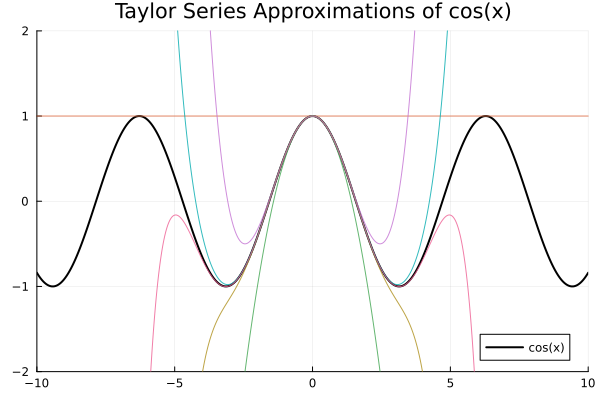

In [14]:
# Set up the domain for our plot.
xx = -10:0.01:10

# Calculate the true cosine values.
yy = cos.(xx)

# In one line, calculate approximations for all x values for degrees 0 through 5.
# The result, yy_taylor, is a matrix where columns correspond to different degrees.
yy_taylor = [ taylor_cos(x, n) for x in xx, n in 0:5 ]

# Now, let's plot it.
using Plots

# Create the plot and add the first series (the true function)
# All global plot settings like title and limits are set here.
plot(xx, yy,
    linewidth = 2,              # Set line width (lw=3 also works)
    color = :black,             # Set line color
    label = "cos(x)",           # Label for the legend
    title = "Taylor Series Approximations of cos(x)",
    xlims = (-10, 10),          # Set x-axis limits
    ylims = (-2, 2)            # Set y-axis limits
)

# Add the Taylor approximation series to the existing plot using plot!()
# Plots.jl automatically plots each column of yy_taylor as a separate line.
plot!(xx, yy_taylor,
    alpha = 0.8,                # Set line transparency
    label = ""                  # Use empty label to avoid cluttering the legend
)

## Querying Arrays: Booleans and Indices

Another powerful set of array functions allows you to ask questions about your data. These functions typically involve boolean logic (`true`/`false`) and are essential for filtering and analyzing arrays.

### Membership and Logical Checks

These functions check for the presence of elements or conditions across an entire array.

In [15]:
# Let's work with the odd numbers from 1 to 999.
x = 1:2:1000

# The `in` function (or the symbol ∈, typed \in<TAB>) checks for membership.
println("Is 503 in x? ", 503 in x)
println("Is 1000 in x? ", 1000 ∈ x)

Is 503 in x? true
Is 1000 in x? false


In [16]:
# The `all()` function returns `true` only if every element satisfies the condition.
println("Are all elements less than 500? ", all(x .< 500)) # false
println("Are all elements greater than 0? ", all(x .> 0))   # true

Are all elements less than 500? false
Are all elements greater than 0? true


In [17]:
# The `any()` function returns `true` if at least one element satisfies the condition.
println("Is any element equal to 503? ", any(x .== 503))    # true
println("Is any element equal to 1000? ", any(x .== 1000)) # false

Is any element equal to 503? true
Is any element equal to 1000? false


### Finding and Counting

Often, it's not enough to know *if* a condition is met; you need to know *where* or *how many times*.

In [18]:
# `findfirst()` returns the index of the first element that satisfies a condition.
idx = findfirst(x .== 503)
println("The value 503 is at index: ", idx)
println("Check: x[", idx, "] = ", x[idx])

The value 503 is at index: 252
Check: x[252] = 503


In [19]:
# `findall()` returns a vector of indices for all elements that satisfy the condition.
# Note: `@.` is a macro that applies the dot to every operation in the expression.
ind = findall(@. x % 97 == 0)
println("Indices of multiples of 97: ", ind)
println("The corresponding values are: ", x[ind])

Indices of multiples of 97: [49, 146, 243, 340, 437]
The corresponding values are: [97, 291, 485, 679, 873]


In [20]:
# `count()` returns the number of elements that satisfy a condition.
num_multiples = count(@. x % 97 == 0)
println("Found ", num_multiples, " multiples of 97.")

Found 5 multiples of 97.
